In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
import copy
import os
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV

from bgspy.nb_utils import load_learnedfuncs_in_dir
from bgspy.learn_utils import fit_dnn, TargetReweighter
from bgspy.learn import LearnedFunction, LearnedB
from bgspy.plots import loss_limits_plot, bhat_plot
import scipy.stats as stats

import gpustat

gpu_stats = gpustat.GPUStatCollection.new_query()
ids = map(lambda gpu: int(gpu.entry['index']), gpu_stats)
ratios = map(lambda gpu: float(gpu.entry['memory.used'])/float(gpu.entry['memory.total']), gpu_stats)
num_gpu = 2
bestGPU = sorted(zip(ids, ratios), key=lambda x: x[1])[:num_gpu]
os.environ['CUDA_VISIBLE_DEVICES'] = ','.join([str(i) for i, r in bestGPU]) 
print(os.environ['CUDA_VISIBLE_DEVICES'])

3,2


In [72]:
bf = LearnedFunction.load("../data/slim_sims/bmap_hg38_reps/bmap_hg38_reps_data.pkl")
bf

LearnedFunction with 5 feature(s)
 variable feature(s):
  - mu ∈ [-10, -7] (log10, None)
  - sh ∈ [-5, -1] (log10, None)
  - L ∈ [1, 10000] (linear, None)
  - rbp ∈ [-12, -7] (log10, None)
  - rf ∈ [-10, -0.824] (log10, None)
 fixed fixed(s) (based on metadata):
Features normalized? False
Features split? False
Total size: 200,000

In [73]:
# full data
yf, Xf = bf.y, bf.X

# smaller test sample
sidx = np.random.randint(0, len(yf), 10000)
y = yf[sidx, :]
X = Xf[sidx, :]

The problem: target distribution is not uniform:

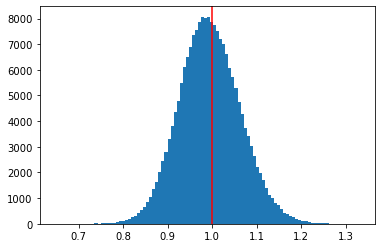

In [76]:
_ = plt.hist(yf, 100)
plt.axvline(1, c='r')

## Random Downsampling

In [8]:
class DownsampleTarget:
    def __init__(self, y, bins='fd', rng=None):
        self.y = y.squeeze()
        self.bins = bins
        self.hist, self.bin_edges = np.histogram(y, bins=bins)
        self.seed = rng if isinstance(rng, int) else None
        self.rng = np.random.default_rng(self.seed) if rng is None else rng

    def downsample(self, level, truncate=True, replace=False):
        bin_item_idx = np.digitize(self.y, self.bin_edges)
        bin_items = defaultdict(list)
        
        for i, idx in enumerate(bin_item_idx.tolist()):
            bin_items[idx].append(i)
        sample = []
        for vals in bin_items.values():
            if len(vals) <= level:
                if not truncate:
                    sample.extend(vals)
            else:
                sample.extend(self.rng.choice(vals, size=level, replace=replace).tolist())
        return np.array(sample)

    def fhat(self, x):
        x = x.squeeze()
        bin_edges = self.bin_edges
        bin_edges[-1] += 1e-6
        dens, _ = np.histogram(y, bins=self.bin_edges, density=True)
        idx = np.digitize(x, bin_edges)
        return dens[idx-1]/self.y.size
        
    def plot(self):
        return plt.bar(self.bin_edges[:-1], self.hist, width=np.diff(self.bin_edges)[0])
    

In [8]:
domain = {'mu': (-10, -7, True),
         'sh': (-5, -1, True),
         'L': (1, 10000, False),
         'rbp': (-12, -7, True),
         'rf': (-10, -0.824, True)}

In [10]:
func_full = LearnedFunction(X, y, seed=1, domain=domain)
func_full.split()
func_full.scale_features()

LearnedFunction with 5 feature(s)
 variable feature(s):
  - mu ∈ [-10, -7] (log10, <ufunc 'log10'>)
  - sh ∈ [-5, -1] (log10, <ufunc 'log10'>)
  - L ∈ [1, 10000] (linear, None)
  - rbp ∈ [-12, -7] (log10, <ufunc 'log10'>)
  - rf ∈ [-10, -0.824] (log10, <ufunc 'log10'>)
 fixed fixed(s) (based on metadata):
Features normalized? True
Features split? True, test size: 20.0% (n=2,000)
Total size: 10,000

In [11]:
# downsample all bins to 100 points

m = DownsampleTarget(y)
idx = m.downsample(level=100)

In [10]:
# randomly downsample to same level as uniform target downsampling

n = X.shape[0]
random_downsample = np.random.choice(np.arange(n), len(idx), replace=False)

func_rand = LearnedFunction(X[random_downsample, :], y[random_downsample, :], seed=1, domain=domain)
func_rand.split()
func_rand.scale_features()

LearnedFunction with 5 feature(s)
 variable feature(s):
  - mu ∈ [-10, -7] (log10, <ufunc 'log10'>)
  - sh ∈ [-5, -1] (log10, <ufunc 'log10'>)
  - L ∈ [1, 10000] (linear, None)
  - rbp ∈ [-12, -7] (log10, <ufunc 'log10'>)
  - rf ∈ [-10, -0.824] (log10, <ufunc 'log10'>)
 fixed fixed(s) (based on metadata):
Features normalized? True
Features split? True, test size: 20.0% (n=580)
Total size: 2,900

(array([ 15.,  65., 278., 666., 850., 620., 293.,  88.,  20.,   5.]),
 array([0.76844963, 0.81800299, 0.86755635, 0.91710971, 0.96666307,
        1.01621643, 1.06576978, 1.11532314, 1.1648765 , 1.21442986,
        1.26398322]),
 <BarContainer object of 10 artists>)

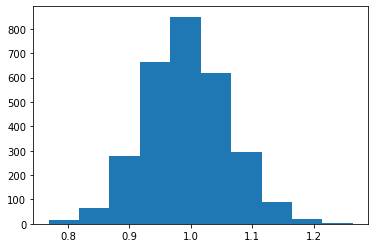

In [11]:
# ensure the target is still ~ gaussian
plt.hist(func_rand.y)

In [12]:
# uniformly downsampled target

func_down = LearnedFunction(X[idx, :], y[idx, ], seed=1, domain=domain)
func_down.split()
func_down.scale_features()

LearnedFunction with 5 feature(s)
 variable feature(s):
  - mu ∈ [-10, -7] (log10, <ufunc 'log10'>)
  - sh ∈ [-5, -1] (log10, <ufunc 'log10'>)
  - L ∈ [1, 10000] (linear, None)
  - rbp ∈ [-12, -7] (log10, <ufunc 'log10'>)
  - rf ∈ [-10, -0.824] (log10, <ufunc 'log10'>)
 fixed fixed(s) (based on metadata):
Features normalized? True
Features split? True, test size: 20.0% (n=580)
Total size: 2,900

(array([295., 288., 283., 283., 301., 296., 288., 283., 294., 289.]),
 array([0.87330363, 0.89739662, 0.92148961, 0.9455826 , 0.96967558,
        0.99376857, 1.01786156, 1.04195455, 1.06604753, 1.09014052,
        1.11423351]),
 <BarContainer object of 10 artists>)

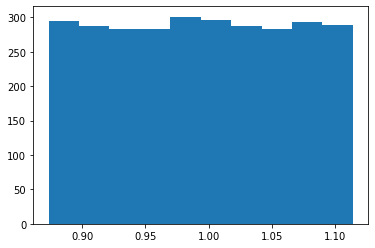

In [13]:
# ensure downsampling work, e.g. target is ~ uniform 

plt.hist(func_down.y)

## Comparing Uniform Downsampling with Random Downsampling

In [12]:
models = dict()
hists = dict()

In [13]:
funcs = dict(rand=func_rand, down=func_down)

NameError: name 'func_rand' is not defined

In [ ]:
%%time
# relu activation, no sample reweighting/downsampling

models['rand relu'], hists['rand relu'] = fit_dnn(funcs['rand'], n128=0, n64=0, n32=0, n8=0, nx=2, output_activation='relu')

In [19]:
%%time
# sigmoid activation, no sample reweighting/downsampling

models['rand sig'], hists['rand sig']= fit_dnn(funcs['rand'], n128=0, n64=0, n32=0, n8=0, nx=2, output_activation='sigmoid')

CPU times: user 1min 4s, sys: 18 s, total: 1min 22s
Wall time: 42.2 s


In [20]:
%%time
# relu activation, uniform reweighting

models['down relu'], hists['down relu'] = fit_dnn(funcs['down'], n128=0, n64=0, n32=0, n8=0, nx=2, output_activation='relu')

CPU times: user 1min 3s, sys: 17.9 s, total: 1min 21s
Wall time: 41.5 s


In [21]:
%%time
# sigmoid activation, uniform reweighting

models['down sig'], hists['down sig'] = fit_dnn(funcs['down'], n128=0, n64=0, n32=0, n8=0, nx=2, output_activation='sigmoid')

CPU times: user 1min 3s, sys: 18.1 s, total: 1min 21s
Wall time: 41.7 s


(0.003, 0.008)

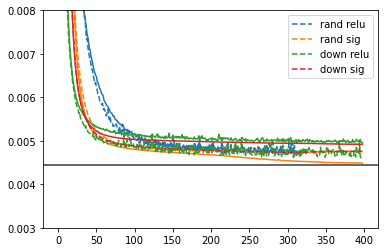

In [31]:
for model in models:
    history = hists[model].history
    lines = plt.plot(history['loss'][1:])
    col = lines[0].get_color()
    plt.plot(history['val_loss'][1:], linestyle='dashed', c=col, label=model)

nreps = 50
plt.axhline(2/(9 * nreps), c='0.22')
plt.legend()
plt.ylim(0.003, 0.008)

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='binned $B_\\mathrm{ML}$', ylabel='$\\hat{B}$'>)

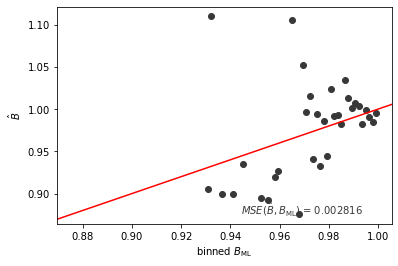

In [32]:
n = 50
func_down.model = models['down sig']
bfunc = LearnedB()
bfunc.func = func_down
bhat_plot(bfunc, n)

So, downsampling + sigmoid output activation leads to low loss, but the fit is still bad. This is in part because we lose so many points due to down sampling. We could down sample with weighting rather than exactly grab *n* items per bin, which could help.

## Sample Reweighting

In [18]:
trw = TargetReweighter(yf[np.random.randint(0, yf.shape[0], 10_000)])
trw.find_optimum_bandwidth(10**np.linspace(-4, 0, 100), n_jobs=50)
trw.y.shape

/home/vsb/miniconda3/envs/bprime/lib/python3.8/site-packages/sklearn/model_selection/_search.py:969: UserWarning: One or more of the test scores are non-finite: [         -inf          -inf          -inf          -inf          -inf
          -inf          -inf          -inf          -inf          -inf
          -inf          -inf          -inf          -inf          -inf
          -inf          -inf          -inf          -inf          -inf
          -inf          -inf          -inf          -inf          -inf
          -inf          -inf          -inf          -inf          -inf
          -inf          -inf          -inf          -inf          -inf
          -inf          -inf          -inf          -inf          -inf
          -inf          -inf          -inf          -inf          -inf
          -inf          -inf          -inf          -inf 2519.52813473
 2520.38513765 2520.98671622 2521.49224459 2522.03520575 2522.49409446
 2522.61773791 2522.75789363 2522.77434271 2522.69429012 2

(10000, 1)

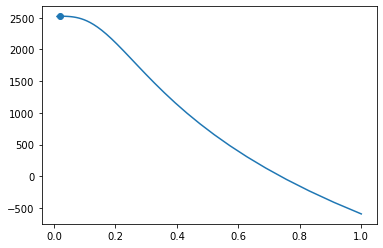

In [19]:
x = np.array(trw._gcv.cv_results_['param_bandwidth'])
plt.plot(x, trw._gcv.cv_results_['mean_test_score'])
plt.scatter(trw._gcv.best_params_['bandwidth'], trw._gcv.best_score_)

In [20]:
trw._gcv.best_params_

{'bandwidth': 0.02009233002565048}

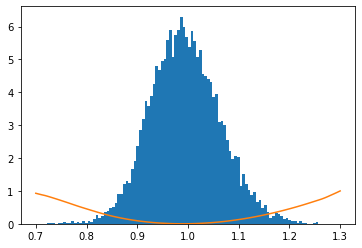

In [23]:
trw.set_bandwidth(0.1)

plt.hist(trw.y, 100, density=True)
x = np.linspace(0.7, 1.3, 100)
plt.plot(x, trw.weights(x))

In [9]:
# all the data
func = LearnedFunction(Xf, yf, seed=1, domain=domain)
func.split()
func.scale_features()

LearnedFunction with 5 feature(s)
 variable feature(s):
  - mu ∈ [-10, -7] (log10, <ufunc 'log10'>)
  - sh ∈ [-5, -1] (log10, <ufunc 'log10'>)
  - L ∈ [1, 10000] (linear, None)
  - rbp ∈ [-12, -7] (log10, <ufunc 'log10'>)
  - rf ∈ [-10, -0.824] (log10, <ufunc 'log10'>)
 fixed fixed(s) (based on metadata):
Features normalized? True
Features split? True, test size: 20.0% (n=40,000)
Total size: 200,000

In [54]:
y_weights = trw.weights(np.copy(func.y_train))

In [47]:
# downsample all bins to 100 points

m = DownsampleTarget(func.y)
y_weights = 1-m.fhat(func.y_train)

In [53]:
y_weights_hist = y_weights

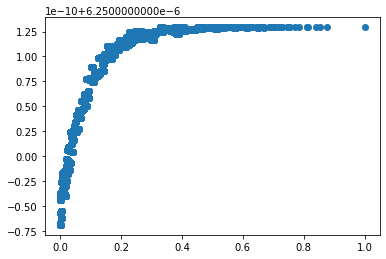

In [59]:
plt.scatter(y_weights, y_weights_hist / y_weights_hist.sum())

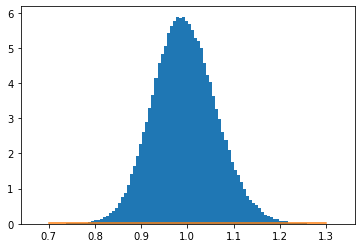

In [64]:
plt.hist(func.y_train, 100, density=True)
x = np.linspace(0.7, 1.3, 100)
ww = m.fhat(x)
z = 1-ww
plt.plot(x, z/z.sum())

In [49]:
models_full = dict()
hists_full = dict()

In [ ]:
%%time
# sigmoid activation, target reweighting

models_full['reweight sig'], hists_full['reweight sig'] = fit_dnn(func, n128=0, n64=0, n32=0, n8=0, nx=2, 
                                                                  sample_weight=y_weights,
                                                                  output_activation='sigmoid')

In [29]:
%%time
# sigmoid activation, no target reweighting

models_full['no-reweight sig'], hists_full['no-reweight sig'] = fit_dnn(func, n128=0, n64=0, n32=0, n8=0, nx=2, 
                                                                        output_activation='sigmoid')

Restoring model weights from the end of the best epoch: 376.
Epoch 00476: early stopping
CPU times: user 57min 14s, sys: 5min 52s, total: 1h 3min 7s
Wall time: 37min 31s


In [30]:
%%time
# relu activation, uniform reweighting

models_full['reweight relu'], hists_full['reweight relu'] = fit_dnn(func, n128=0, n64=0, n32=0, n8=0, nx=2, 
                                                                  sample_weight=y_weights,
                                                                  output_activation='relu')

Restoring model weights from the end of the best epoch: 152.
Epoch 00252: early stopping
CPU times: user 36min 35s, sys: 4min 11s, total: 40min 47s
Wall time: 23min 11s


In [31]:
%%time
# relu activation, uniform reweighting

models_full['no-reweight relu'], hists_full['no-reweight relu'] = fit_dnn(func, n128=0, n64=0, n32=0, n8=0, nx=2, 
                                                                        output_activation='relu')

CPU times: user 59min 33s, sys: 6min 4s, total: 1h 5min 37s
Wall time: 39min 3s


[]

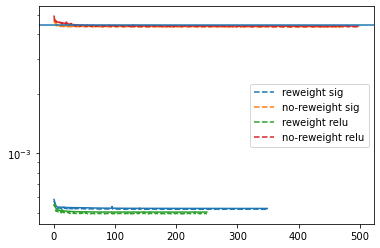

In [32]:
for model in models_full:
    history = hists_full[model].history
    lines = plt.plot(history['loss'][1:])
    col = lines[0].get_color()
    plt.plot(history['val_loss'][1:], linestyle='dashed', c=col, label=model)

nreps = 50
plt.axhline(2/(9*nreps))
plt.legend()
#plt.ylim(0, 0.004)
plt.semilogy()

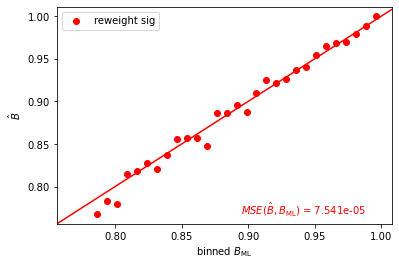

In [96]:
n = 30

figax = plt.subplots()

cols = ['r', 'g', 'b', 'orange']

for i, model in enumerate(models_full):
    func.model = models_full[model]
    bfunc = LearnedB()
    bfunc.func = func
    bfunc.func.history = hists_full[model].history
    figax = bhat_plot(bfunc, n, figax=figax, c=cols[i], label=model, label_pos=(0.55, 0.05 + 0.05*i))

plt.legend()

(<Figure size 720x504 with 4 Axes>,
 ((<AxesSubplot:xlabel='$\\mu/s$', ylabel='predicted'>,
   <AxesSubplot:xlabel='epoch', ylabel='MSE'>),
  (<AxesSubplot:xlabel='binned $B_\\mathrm{ML}$', ylabel='$\\hat{B}$'>,
   <AxesSubplot:xlabel='predicted', ylabel='validation loss'>)))

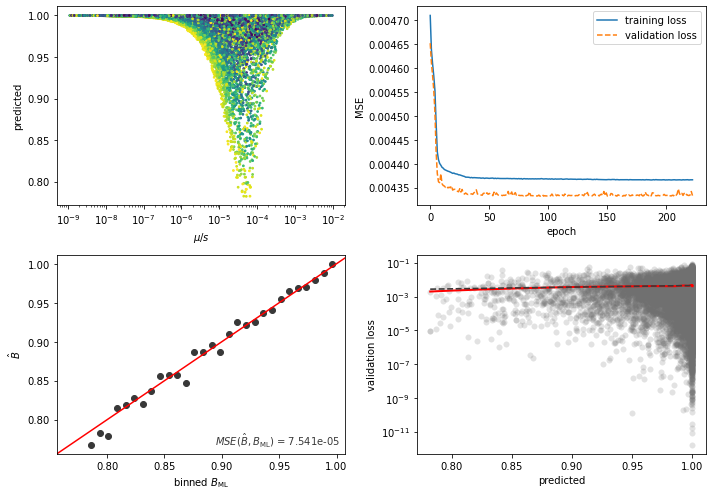

In [80]:
from bgspy.plots import b_learn_diagnostic_plot

b_learn_diagnostic_plot(bfunc, panel='bhat', R=50,
                        bins=30,
                        n={'mu': 10, 'sh': 10, 'L':10, 'rbp':10, 'rf': 10}, c='L', add_theory=False)

In [10]:
from sklearn.preprocessing import PolynomialFeatures 

from sklearn.linear_model import Ridge, LinearRegression, TweedieRegressor
from sklearn.pipeline import make_pipeline
import statsmodels.api as sm


In [12]:
model = make_pipeline(PolynomialFeatures(5), LinearRegression())
model.fit(func.X_train, func.y_train)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=5)),
                ('linearregression', LinearRegression())])

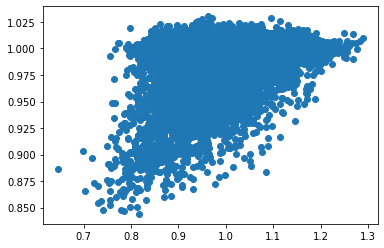

In [13]:
plt.scatter(func.y_test, model.predict(func.X_test))

In [15]:
bfunc = LearnedB()
bfunc.func = func 
bfunc.func.model = model

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='binned $B_\\mathrm{ML}$', ylabel='$\\hat{B}$'>)

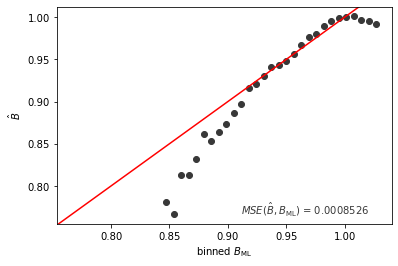

In [16]:
bhat_plot(bfunc, 30)

In [66]:
polynomial_features= PolynomialFeatures(degree=5)

xp_train = polynomial_features.fit_transform(func.X_train)
xp_test = polynomial_features.fit_transform(func.X_test)

In [67]:
model = make_pipeline(PolynomialFeatures(8), Ridge(alpha=1e-2))
model.fit(func.X_train, np.log(func.y_train))

ypred = model.predict(func.X_test) 

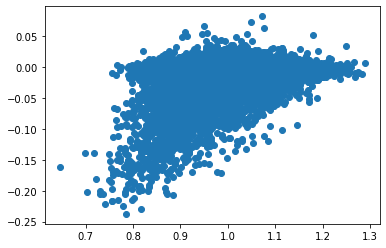

In [68]:
plt.scatter(func.y_test, ypred)

0.0009833524334579619


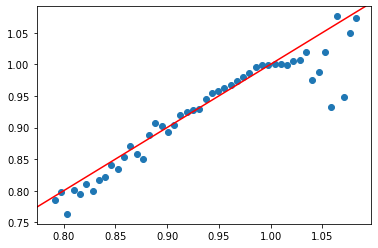

In [71]:
nbins  = 50
yp = np.exp(ypred)
bins = np.linspace(yp.min(), yp.max(), nbins)
y_bins = stats.binned_statistic(yp, func.y_test, bins=bins)
edges = y_bins.bin_edges
x = 0.5*(edges[:-1]+edges[1:])
y =  y_bins.statistic
plt.scatter(x, y)
o = min(edges)
plt.axline((o, o), slope=1, c='r')
print(np.nanmean((x - y)**2))

[]

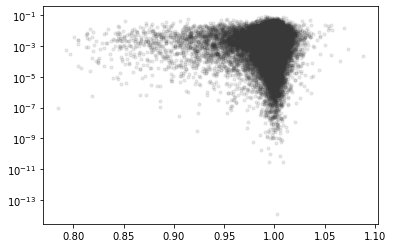

In [57]:
plt.scatter(ypred, (func.y_test-ypred)**2, c='0.22', alpha=0.1, s=10)
plt.semilogy()

In [31]:
model.score()

TypeError: score() missing 1 required positional argument: 'X'

In [191]:
models_full.keys()

dict_keys(['reweight sig'])

OLD STUFF

In [ ]:
history = hist.history
history_sig = hist_sig.history
history_rand = hist_rand.history
history_full = hist_full.history
history_relu = hist_relu.history


plt.plot(history['loss'][1:], c='b')
plt.plot(history['val_loss'][1:], linestyle='dashed', c='b', label='uniformly downsampled target')

plt.plot(history_rand['loss'][1:], c='g')
plt.plot(history_rand['val_loss'][1:], linestyle='dashed', c='g', label='randomly downsampled target')

plt.plot(history_full['loss'][1:], c='r')
plt.plot(history_full['val_loss'][1:], linestyle='dashed', c='r', label='sample weighting')

plt.plot(history_relu['loss'][1:], c='purple')
plt.plot(history_relu['val_loss'][1:], linestyle='dashed', c='purple', label='just relu')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.ylim(0.004, 0.005)

In [ ]:
trw = TargetReweighter(y[idx, ])
trw.find_optimum_bandwidth(np.linspace(1e-1, 2, 100), n_jobs=50)
trw.y.shape

In [47]:

# sigmoid activation, no sample reweighting

model_sig, hist_sig = fit_dnn(func_full, n128=0, n64=0, n32=0, n8=0, nx=2, output_activation='sigmoid')

Restoring model weights from the end of the best epoch: 110.
Epoch 00210: early stopping
CPU times: user 25min 6s, sys: 2min 20s, total: 27min 26s
Wall time: 16min 34s


In [48]:
%%time
model_sig_reweight, hist_sig_reweight = fit_dnn(func_full, n128=0, n64=0, n32=0, n8=0, nx=2, sample_weight=1-sample_weight, output_activation='sigmoid')

Restoring model weights from the end of the best epoch: 238.
Epoch 00338: early stopping
CPU times: user 48min 41s, sys: 5min 23s, total: 54min 4s
Wall time: 30min 40s


In [20]:
%%time
model, hist = fit_dnn(func, n128=0, n64=0, n32=0, n8=0, nx=2, output_activation='relu')

CPU times: user 11min 49s, sys: 1min 26s, total: 13min 16s
Wall time: 7min 53s


In [21]:
%%time
model_rand, hist_rand = fit_dnn(func_rand, n128=0, n64=0, n32=0, n8=0, nx=2, output_activation='relu')

CPU times: user 10min 56s, sys: 1min 20s, total: 12min 16s
Wall time: 7min 21s


In [22]:
mfull = DownsampleTarget(y, 100)

sample_weight = mfull.fhat(y)

In [30]:
%%time
model_full, hist_full = fit_dnn(func_full, n128=0, n64=0, n32=0, n8=0, nx=4, 
                                sample_weight=1-sample_weight, output_activation='relu')

CPU times: user 1h 8min 33s, sys: 7min 6s, total: 1h 15min 39s
Wall time: 45min 25s


In [ ]:
%%time
model_relu, hist_relu = fit_dnn(func_full, n128=0, n64=0, n32=0, n8=0, nx=2, 
                                sample_weight=None, output_activation='relu')

(0.004, 0.005)

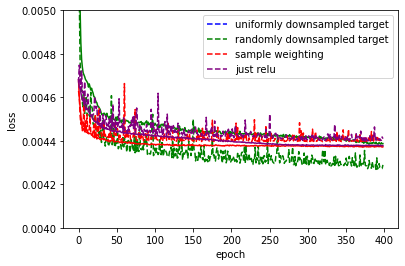

In [50]:
history = hist.history
history_sig = hist_sig.history
history_rand = hist_rand.history
history_full = hist_full.history
history_relu = hist_relu.history


plt.plot(history['loss'][1:], c='b')
plt.plot(history['val_loss'][1:], linestyle='dashed', c='b', label='uniformly downsampled target')

plt.plot(history_rand['loss'][1:], c='g')
plt.plot(history_rand['val_loss'][1:], linestyle='dashed', c='g', label='randomly downsampled target')

plt.plot(history_full['loss'][1:], c='r')
plt.plot(history_full['val_loss'][1:], linestyle='dashed', c='r', label='sample weighting')

plt.plot(history_relu['loss'][1:], c='purple')
plt.plot(history_relu['val_loss'][1:], linestyle='dashed', c='purple', label='just relu')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.ylim(0.004, 0.005)

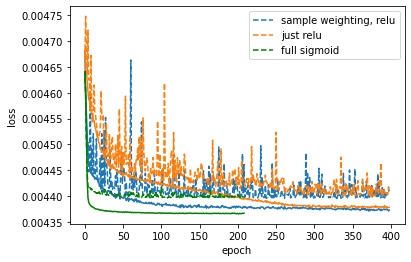

In [51]:
line = plt.plot(history_full['loss'][1:])
plt.plot(history_full['val_loss'][1:], linestyle='dashed', c=line[0].get_color(), label='sample weighting, relu')

plt.xlabel('epoch')
plt.ylabel('loss')

line = plt.plot(history_relu['loss'][1:])
plt.plot(history_relu['val_loss'][1:], linestyle='dashed', c=line[0].get_color(), label='just relu')

plt.xlabel('epoch')
plt.ylabel('loss')


plt.plot(history_sig['loss'][1:], c='g')
plt.plot(history_sig['val_loss'][1:], linestyle='dashed', c='g', label='full sigmoid')
plt.legend()

Text(0, 0.5, 'loss')

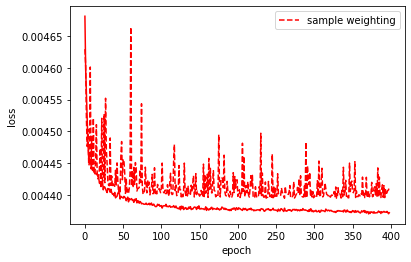

In [33]:


plt.plot(history_full['loss'][1:], c='r')
plt.plot(history_full['val_loss'][1:], linestyle='dashed', c='r', label='sample weighting')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')

In [34]:
func.model = model
func_rand.model = model_rand
func_full.model = model_full

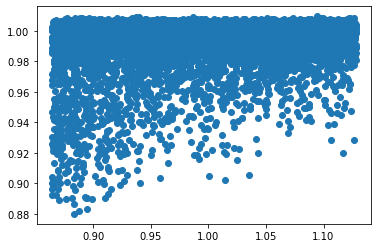

In [35]:
plt.scatter(func.y_test, func.predict_test())

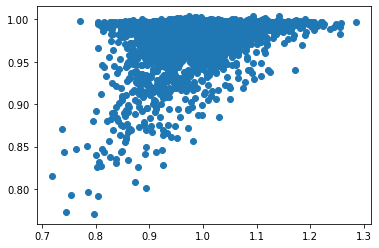

In [36]:
plt.scatter(func_rand.y_test, func_rand.predict_test())

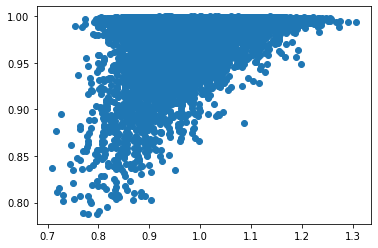

In [37]:
plt.scatter(func_full.y_test, func_full.predict_test())

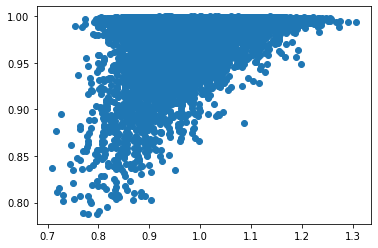

In [38]:
plt.scatter(func_full.y_test, func_full.predict_test())

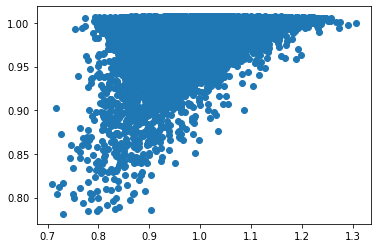

In [39]:
func_full.model = model_relu
plt.scatter(func_full.y_test, func_full.predict_test())

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='binned $B_\\mathrm{ML}$', ylabel='$\\hat{B}$'>)

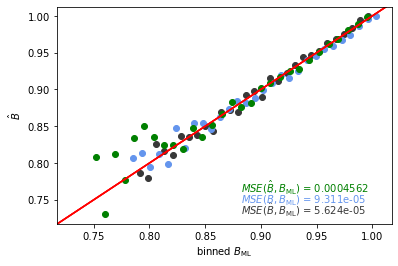

In [53]:
n = 30

figax = plt.subplots()

func_full.model = model_full
bfunc = LearnedB()
bfunc.func = func_full
figax = bhat_plot(bfunc, n, figax=figax)

func_full.model = model_relu
bfunc = LearnedB()
bfunc.func = func_full
bhat_plot(bfunc, n, figax=figax, label_pos=(0.55, 0.1), c='cornflowerblue')


func_full.model = model_sig
bfunc = LearnedB()
bfunc.func = func_full
bhat_plot(bfunc, n, figax=figax, label_pos=(0.55, 0.15), c='g')

In [ ]:
k